# Data Collection - Market Impact & Almgren-Chriss Models

## Objective
This notebook collects and processes market data necessary to estimate Almgren-Chriss model parameters:
- High-frequency market data (OHLCV)
- Daily volume aggregation and intraday volume profiles
- Market parameters: volatility, volume, spreads

## Data Sources
1. **Stocks**: Databento (Nasdaq TotalView-ITCH) via S3 - minute-level data
2. **Cryptocurrencies**: Binance Public API - minute-level OHLCV

## Outputs
- Raw data: `data/raw/stocks/` and `data/raw/crypto/`
- Processed data: `data/processed/stocks/` and `data/processed/crypto/`
- Market parameters: `data/processed/market_parameters.csv`

## 1. Setup & Configuration

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# File system
import os
from pathlib import Path
import json
import time

# Data APIs
import requests
import s3fs
import pytz

# Matplotlib configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('Imports successful')

Imports successful


In [2]:
# Create directory structure
Path('data/raw/stocks').mkdir(parents=True, exist_ok=True)
Path('data/raw/crypto').mkdir(parents=True, exist_ok=True)
Path('data/processed/stocks').mkdir(parents=True, exist_ok=True)
Path('data/processed/crypto').mkdir(parents=True, exist_ok=True)
Path('results/figures').mkdir(parents=True, exist_ok=True)

print('Directory structure created')

Directory structure created


## 2. Stock Data Collection (Databento via S3)

### Configuration
- **Source**: Databento (Nasdaq TotalView-ITCH)
- **Tickers**: AAPL, MSFT, GOOG
- **Timeframe**: January - June 2025 (6 months)
- **Frequency**: 1-minute bars

In [3]:
# S3 Configuration (optional - skip if not in SSPCloud)
STOCK_TICKERS = ['AAPL', 'MSFT', 'GOOG']
BUCKET = 'gmarguier'
PREFIX = 'diffusion/market-impact-model/databento'

# Try to connect to S3 (will skip if credentials not available)
try:
    s3 = s3fs.S3FileSystem(
        client_kwargs={'endpoint_url': 'https://minio.lab.sspcloud.fr'}
    )
    # Test connection
    s3.ls(BUCKET)
    ENABLE_STOCK_COLLECTION = True
    print(f'S3 connection successful')
    print(f'Stock tickers: {", ".join(STOCK_TICKERS)}')
except Exception as e:
    ENABLE_STOCK_COLLECTION = False
    print(f'S3 connection failed: {e}')
    print(f'Stock data collection will be skipped')
    print(f'   To enable stock data collection, run this notebook in SSPCloud')
    print(f'   or configure AWS credentials locally')
    print(f'\n   Continuing with crypto data only...')

S3 connection successful
Stock tickers: AAPL, MSFT, GOOG


In [4]:
def convert_databento_format(df, ticker):
    """Convert Databento format to standard OHLCV format"""
    column_mapping = {
        'ts_event': 'datetime',
        'open': 'open',
        'high': 'high',
        'low': 'low',
        'close': 'close',
        'volume': 'volume'
    }
    
    df = df.rename(columns=column_mapping)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    df.sort_index(inplace=True)
    df['ticker'] = ticker
    
    return df[['open', 'high', 'low', 'close', 'volume', 'ticker']]

def load_stock_data_from_s3(ticker, bucket, prefix):
    """Load all files for a ticker from S3 and concatenate"""
    ticker_folder = f"{bucket}/{prefix}/{ticker}"
    
    print(f'\nLoading {ticker}...')
    
    try:
        files = s3.glob(f"{ticker_folder}/*.csv.zst")
        
        if not files:
            print(f' No files found in {ticker_folder}')
            return pd.DataFrame()
        
        print(f'  Found {len(files)} file(s)')
        
        dfs = []
        for file_path in files:
            try:
                with s3.open(file_path, 'rb') as f:
                    df = pd.read_csv(f, compression='zstd', parse_dates=['ts_event'])
                    dfs.append(df)
            except Exception as e:
                print(f' Error: {e}')
        
        if not dfs:
            return pd.DataFrame()
        
        combined_df = pd.concat(dfs, ignore_index=True)
        combined_df = convert_databento_format(combined_df, ticker)
        combined_df = combined_df[~combined_df.index.duplicated(keep='first')]
        combined_df.sort_index(inplace=True)
        
        print(f'Total: {len(combined_df):,} unique rows')
        return combined_df
        
    except Exception as e:
        print(f'Error: {e}')
        return pd.DataFrame()

print('Stock data loading functions created')

Stock data loading functions created


In [5]:
# Load stock data (only if S3 is available)
stock_data = {}

if ENABLE_STOCK_COLLECTION:
    for ticker in STOCK_TICKERS:
        df = load_stock_data_from_s3(ticker, BUCKET, PREFIX)
        if not df.empty:
            stock_data[ticker] = df

    print(f'\nLoading complete: {len(stock_data)} tickers')
    for ticker, df in stock_data.items():
        print(f'{ticker}: {df.index.min()} → {df.index.max()} ({len(df):,} rows)')
else:
    print('\nkipping stock data collection (S3 not available)')
    print('   Stock data will not be included in parameters')


Loading AAPL...
  Found 6 file(s)
Total: 99,818 unique rows

Loading MSFT...
  Found 6 file(s)
Total: 90,422 unique rows

Loading GOOG...
  Found 6 file(s)
Total: 92,040 unique rows

Loading complete: 3 tickers
AAPL: 2025-01-02 09:00:00+00:00 → 2025-06-27 23:59:00+00:00 (99,818 rows)
MSFT: 2025-01-02 09:00:00+00:00 → 2025-06-27 23:53:00+00:00 (90,422 rows)
GOOG: 2025-01-02 09:01:00+00:00 → 2025-06-27 23:59:00+00:00 (92,040 rows)


In [6]:
# Process stock data (only if available)
processed_stock_data = {}

if ENABLE_STOCK_COLLECTION and len(stock_data) > 0:
    def filter_regular_trading_hours(df):
        """Keep only regular NASDAQ trading hours: 9:30 AM - 4:00 PM ET"""
        eastern = pytz.timezone('US/Eastern')
        df_et = df.copy()
        df_et.index = df_et.index.tz_convert(eastern)
        
        market_open = pd.Timestamp('09:30:00').time()
        market_close = pd.Timestamp('16:00:00').time()
        
        mask = (df_et.index.time >= market_open) & (df_et.index.time < market_close)
        df_filtered = df_et[mask].copy()
        df_filtered.index = df_filtered.index.tz_convert('UTC')
        
        return df_filtered

    for ticker, df in stock_data.items():
        df_ticker = filter_regular_trading_hours(df)
        df_ticker = df_ticker.reset_index()
        df_ticker.columns = [col.lower() if isinstance(col, str) else col for col in df_ticker.columns]
        df_ticker['datetime'] = pd.to_datetime(df_ticker['datetime'])
        df_ticker = df_ticker.set_index('datetime').sort_index()
        df_ticker['mid_price'] = (df_ticker['high'] + df_ticker['low']) / 2
        
        processed_stock_data[ticker] = df_ticker
        print(f'{ticker} processed: {len(df_ticker):,} rows')

    # Concatenate all stock data
    df_stocks = pd.concat(processed_stock_data.values(), axis=0).sort_index()
    print(f'\nStock market data formatted:')
    print(f'   - Rows: {len(df_stocks):,}')
    print(f'   - Period: {df_stocks.index.min()} → {df_stocks.index.max()}')
    print(f'   - Tickers: {df_stocks["ticker"].unique()}')
else:
    print('No stock data to process')

AAPL processed: 47,190 rows
MSFT processed: 47,190 rows
GOOG processed: 47,190 rows

Stock market data formatted:
   - Rows: 141,570
   - Period: 2025-01-02 14:30:00+00:00 → 2025-06-27 19:59:00+00:00
   - Tickers: ['AAPL' 'MSFT' 'GOOG']


## 3. Cryptocurrency Data Collection (Binance API)

### Configuration
- **Source**: Binance Public API (no authentication required)
- **Symbols**: BTCUSDT, ETHUSDT, SOLUSDT
- **Timeframe**: November 2025 (1 month)
- **Frequency**: 1-minute OHLCV

In [7]:
class BinanceDataCollector:
    """Class to collect OHLCV data from Binance API"""
    
    def __init__(self, base_url='https://api.binance.com'):
        self.base_url = base_url
        self.session = requests.Session()
        
    def get_klines(self, symbol, interval, start_time=None, end_time=None, limit=1000):
        """Fetch OHLCV data for a symbol"""
        endpoint = f'{self.base_url}/api/v3/klines'
        
        params = {'symbol': symbol, 'interval': interval, 'limit': limit}
        
        if isinstance(start_time, str):
            start_time = int(pd.Timestamp(start_time).timestamp() * 1000)
        if isinstance(end_time, str):
            end_time = int(pd.Timestamp(end_time).timestamp() * 1000)
            
        if start_time:
            params['startTime'] = start_time
        if end_time:
            params['endTime'] = end_time
        
        try:
            response = self.session.get(endpoint, params=params, timeout=10)
            response.raise_for_status()
            data = response.json()
            
            df = pd.DataFrame(data, columns=[
                'timestamp', 'open', 'high', 'low', 'close', 'volume',
                'close_time', 'quote_volume', 'trades', 'taker_buy_base',
                'taker_buy_quote', 'ignore'
            ])
            
            df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume', 'trades']].copy()
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            
            for col in ['open', 'high', 'low', 'close', 'volume']:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            df['trades'] = df['trades'].astype(int)
            
            return df
            
        except requests.exceptions.RequestException as e:
            print(f'Request error: {e}')
            return None
    
    def get_historical_data(self, symbol, interval, start_date, end_date=None):
        """Fetch complete history with automatic pagination"""
        if end_date is None:
            end_date = datetime.now().strftime('%Y-%m-%d')
        
        start_ts = int(pd.Timestamp(start_date).timestamp() * 1000)
        end_ts = int(pd.Timestamp(end_date).timestamp() * 1000)
        
        all_data = []
        current_ts = start_ts
        
        print(f'Fetching {symbol} data ({interval})')
        print(f'   Period: {start_date} → {end_date}')
        
        while current_ts < end_ts:
            df = self.get_klines(symbol, interval, start_time=current_ts, end_time=end_ts, limit=1000)
            
            if df is None or len(df) == 0:
                break
            
            all_data.append(df)
            current_ts = int(df['timestamp'].iloc[-1].timestamp() * 1000) + 1
            time.sleep(0.1)  # Respect rate limits
        
        if not all_data:
            print('No data retrieved')
            return None
        
        full_df = pd.concat(all_data, ignore_index=True)
        full_df = full_df.drop_duplicates(subset=['timestamp']).reset_index(drop=True)
        full_df = full_df.sort_values('timestamp').reset_index(drop=True)
        
        print(f'Total: {len(full_df):,} rows retrieved')
        return full_df

print('BinanceDataCollector class created')

BinanceDataCollector class created


In [8]:
# Crypto collection configuration
CRYPTO_SYMBOLS = ['BTCUSDT', 'ETHUSDT', 'SOLUSDT']
INTERVAL = '1m'
START_DATE = '2025-11-01'
END_DATE = '2025-12-01'

print(f'Configuration:')
print(f'  Symbols: {", ".join(CRYPTO_SYMBOLS)}')
print(f'  Interval: {INTERVAL}')
print(f'  Period: {START_DATE} → {END_DATE}')

Configuration:
  Symbols: BTCUSDT, ETHUSDT, SOLUSDT
  Interval: 1m
  Period: 2025-11-01 → 2025-12-01


In [9]:
# Collect crypto data
collector = BinanceDataCollector()
crypto_data = {}

for symbol in CRYPTO_SYMBOLS:
    print(f'\n{"="*70}')
    df = collector.get_historical_data(symbol, INTERVAL, START_DATE, END_DATE)
    
    if df is not None:
        crypto_data[symbol] = df
        print(f'\nSummary {symbol}:')
        print(f'   Shape: {df.shape}')
        print(f'   Period: {df["timestamp"].min()} → {df["timestamp"].max()}')
        print(f'   Avg price: ${df["close"].mean():.2f}')
        print(f'   Avg volume: {df["volume"].mean():.2f}')
    else:
        print(f'Failed to retrieve data for {symbol}')
    
    time.sleep(0.5)

print(f'\n{"="*70}')
print(f'Collection complete: {len(crypto_data)} symbols')


Fetching BTCUSDT data (1m)
   Period: 2025-11-01 → 2025-12-01
Total: 43,201 rows retrieved

Summary BTCUSDT:
   Shape: (43201, 7)
   Period: 2025-11-01 00:00:00 → 2025-12-01 00:00:00
   Avg price: $96573.75
   Avg volume: 18.17

Fetching ETHUSDT data (1m)
   Period: 2025-11-01 → 2025-12-01
Total: 43,201 rows retrieved

Summary ETHUSDT:
   Shape: (43201, 7)
   Period: 2025-11-01 00:00:00 → 2025-12-01 00:00:00
   Avg price: $3222.25
   Avg volume: 410.97

Fetching SOLUSDT data (1m)
   Period: 2025-11-01 → 2025-12-01
Total: 43,201 rows retrieved

Summary SOLUSDT:
   Shape: (43201, 7)
   Period: 2025-11-01 00:00:00 → 2025-12-01 00:00:00
   Avg price: $148.82
   Avg volume: 2895.70

Collection complete: 3 symbols


In [10]:
def validate_and_clean_crypto_data(df, symbol):
    """Validate and clean OHLCV data"""
    print(f'\n🔍 Validation for {symbol}')
    print(f'   Initial shape: {df.shape}')
    
    df_clean = df.copy()
    initial_rows = len(df_clean)
    
    # Remove missing values
    df_clean = df_clean.dropna()
    
    # Check OHLC consistency
    inconsistent = (
        (df_clean['high'] < df_clean['low']) |
        (df_clean['high'] < df_clean['open']) |
        (df_clean['high'] < df_clean['close']) |
        (df_clean['low'] > df_clean['open']) |
        (df_clean['low'] > df_clean['close'])
    )
    df_clean = df_clean[~inconsistent]
    
    # Remove zero volume
    df_clean = df_clean[df_clean['volume'] > 0]
    
    final_rows = len(df_clean)
    print(f'   Final shape: {df_clean.shape}')
    print(f'   Rows removed: {initial_rows - final_rows} ({(initial_rows - final_rows)/initial_rows*100:.2f}%)')
    
    return df_clean

# Clean crypto data
clean_crypto_data = {}
for symbol, df in crypto_data.items():
    df_clean = validate_and_clean_crypto_data(df, symbol)
    clean_crypto_data[symbol] = df_clean


🔍 Validation for BTCUSDT
   Initial shape: (43201, 7)
   Final shape: (43201, 7)
   Rows removed: 0 (0.00%)

🔍 Validation for ETHUSDT
   Initial shape: (43201, 7)
   Final shape: (43201, 7)
   Rows removed: 0 (0.00%)

🔍 Validation for SOLUSDT
   Initial shape: (43201, 7)
   Final shape: (43201, 7)
   Rows removed: 0 (0.00%)


## 4. Market Parameters Estimation

For each asset, calculate:
1. **σ (Volatility)**: Annualized volatility
2. **V (Volume)**: Average daily volume
3. **S₀ (Price)**: Reference price
4. **Spread**: Bid-ask spread estimation

In [11]:
def compute_market_parameters(df, symbol, asset_type, interval='1m'):
    """Compute market parameters for Almgren-Chriss model"""
    print(f'\nComputing parameters for {symbol}')
    
    # Calculate returns
    df['returns'] = df['close'].pct_change()
    
    # 1. VOLATILITY
    vol_interval = df['returns'].std()
    
    # Annualize volatility
    if interval == '1m':
        intervals_per_day = 1440 if asset_type == 'crypto' else 390  # 24h vs 6.5h trading
    else:
        intervals_per_day = 1
    
    vol_daily = vol_interval * np.sqrt(intervals_per_day)
    vol_annual = vol_daily * np.sqrt(365 if asset_type == 'crypto' else 252)
    
    print(f'   σ (volatility):')
    print(f'      Per interval ({interval}): {vol_interval:.6f}')
    print(f'      Daily: {vol_daily:.6f}')
    print(f'      Annualized: {vol_annual:.4f} ({vol_annual*100:.2f}%)')
    
    # 2. VOLUME
    # Déterminer les intervalles par jour (390 pour stock, 1440 pour crypto)
    if interval == '1m':
        intervals_per_day = 1440 if asset_type == 'crypto' else 390  # 24h vs 6.5h trading
    else:
        intervals_per_day = 1

    # Volume total par minute
    V_per_minute = df['volume'].mean()

    # Volume total journalier moyen (ADV)
    V_per_day = V_per_minute * intervals_per_day
    
    print(f'   V (avg daily volume): {V_per_day:,.0f}')

    df['date'] = pd.to_datetime(df.index)
    daily_volume = df.groupby('date')['volume'].sum()
    
    # 3. PRICE
    S0_median = df['close'].median()
    S0_recent = df['close'].iloc[-1]
    
    print(f'   S₀ (price):')
    print(f'      Median: ${S0_median:.2f}')
    print(f'      Recent: ${S0_recent:.2f}')
    
    # 4. SPREAD
    df['spread_pct'] = (df['high'] - df['low']) / df['close'] * 100
    spread_mean = df['spread_pct'].mean()
    spread_median = df['spread_pct'].median()
    
    print(f'   Spread (High-Low estimate):')
    print(f'      Mean: {spread_mean:.4f}%')
    print(f'      Median: {spread_median:.4f}%')
    
    return {
        'symbol': symbol,
        'asset_type': asset_type,
        'interval': interval,
        'vol_interval': vol_interval,
        'vol_daily': vol_daily,
        'vol_annual': vol_annual,
        'volume_per_minute': V_per_minute,
        'volume_per_day': V_per_day,
        'S0_median': S0_median,
        'S0_recent': S0_recent,
        'spread_pct_mean': spread_mean,
        'spread_pct_median': spread_median,
        'spread_bps_mean': spread_mean * 100,
        'num_trading_days': len(daily_volume),
        'num_intervals': len(df),
    }

print('Parameter computation function created')

Parameter computation function created


In [12]:
# Compute parameters for all assets
all_parameters = []

# Stock parameters (only if available)
if len(processed_stock_data) > 0:
    for ticker, df in processed_stock_data.items():
        params = compute_market_parameters(df.reset_index(), ticker, 'stock', '1m')
        all_parameters.append(params)

# Crypto parameters
for symbol, df in clean_crypto_data.items():
    params = compute_market_parameters(df, symbol, 'crypto', '1m')
    all_parameters.append(params)

# Create parameters DataFrame
df_params = pd.DataFrame(all_parameters)

print('\n' + '='*70)
print('MARKET PARAMETERS SUMMARY')
print('='*70)
print(df_params[['symbol', 'asset_type', 'vol_annual', 'volume_per_day', 'S0_recent', 'spread_bps_mean']].to_string(index=False))


Computing parameters for AAPL
   σ (volatility):
      Per interval (1m): 0.001270
      Daily: 0.025089
      Annualized: 0.3983 (39.83%)
   V (avg daily volume): 10,782,696
   S₀ (price):
      Median: $212.71
      Recent: $201.10
   Spread (High-Low estimate):
      Mean: 0.1110%
      Median: 0.0821%

Computing parameters for MSFT
   σ (volatility):
      Per interval (1m): 0.001045
      Daily: 0.020641
      Annualized: 0.3277 (32.77%)
   V (avg daily volume): 4,108,588
   S₀ (price):
      Median: $415.20
      Recent: $495.88
   Spread (High-Low estimate):
      Mean: 0.0865%
      Median: 0.0651%

Computing parameters for GOOG
   σ (volatility):
      Per interval (1m): 0.001145
      Daily: 0.022614
      Annualized: 0.3590 (35.90%)
   V (avg daily volume): 5,880,532
   S₀ (price):
      Median: $171.20
      Recent: $178.39
   Spread (High-Low estimate):
      Mean: 0.1086%
      Median: 0.0832%

Computing parameters for BTCUSDT
   σ (volatility):
      Per interval (1m): 

## 5. Save Processed Data

In [13]:
# Save stock data (only if available)
if len(processed_stock_data) > 0:
    for ticker, df in processed_stock_data.items():
        filename = f'data/processed/stocks/{ticker}_1m.parquet'
        df.to_parquet(filename)
        print(f'{filename} saved ({len(df):,} rows)')

    # Save combined stock data
    df_stocks.to_parquet('data/processed/stocks/all_stocks_1m.parquet')
    print(f'data/processed/stocks/all_stocks_1m.parquet saved')
else:
    print('No stock data to save')

# Save crypto data
for symbol, df in clean_crypto_data.items():
    filename = f'data/processed/crypto/{symbol}_1m.parquet'
    df.to_parquet(filename, index=False)
    print(f'{filename} saved ({len(df):,} rows)')

# Save market parameters
df_params.to_parquet('data/processed/market_parameters.parquet', index=False)
df_params.to_csv('data/processed/market_parameters.csv', index=False)
print(f'Market parameters saved')

# Save metadata
metadata = {
    'collection_date': datetime.now().isoformat(),
    'stock_tickers': STOCK_TICKERS if ENABLE_STOCK_COLLECTION else [],
    'crypto_symbols': CRYPTO_SYMBOLS,
    'interval': '1m',
    'total_assets': len(df_params),
    's3_enabled': ENABLE_STOCK_COLLECTION
}

with open('data/processed/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print('Metadata saved')

# Upload to S3 if on SSP Cloud
if ENABLE_STOCK_COLLECTION:
    print('\nUploading processed data to S3...')
    try:
        # Upload processed stocks
        for ticker in processed_stock_data.keys():
            local_file = f'data/processed/stocks/{ticker}_1m.parquet'
            s3_path = f'{BUCKET}/diffusion/market-impact-data/processed/stocks/{ticker}_1m.parquet'
            s3.put(local_file, s3_path)
            print(f'   Uploaded {ticker} to S3')
        
        # Upload combined stocks
        if len(processed_stock_data) > 0:
            s3.put('data/processed/stocks/all_stocks_1m.parquet', 
                   f'{BUCKET}/diffusion/market-impact-data/processed/stocks/all_stocks_1m.parquet')
            print(f'   Uploaded combined stocks to S3')
        
        # Upload crypto data
        for symbol in clean_crypto_data.keys():
            local_file = f'data/processed/crypto/{symbol}_1m.parquet'
            s3_path = f'{BUCKET}/diffusion/market-impact-data/processed/crypto/{symbol}_1m.parquet'
            s3.put(local_file, s3_path)
            print(f'   Uploaded {symbol} to S3')
        
        # Upload parameters
        s3.put('data/processed/market_parameters.parquet', 
               f'{BUCKET}/diffusion/market-impact-data/processed/market_parameters.parquet')
        s3.put('data/processed/market_parameters.csv', 
               f'{BUCKET}/diffusion/market-impact-data/processed/market_parameters.csv')
        s3.put('data/processed/metadata.json', 
               f'{BUCKET}/diffusion/market-impact-data/processed/metadata.json')
        print(f'   Uploaded market parameters to S3')
        
        print(f'\nAll data uploaded to S3: s3://{BUCKET}/diffusion/market-impact-data/processed/')
    except Exception as e:
        print(f'  S3 upload failed: {e}')

print('\n' + '='*70)
print('DATA COLLECTION COMPLETE')
print('='*70)
if not ENABLE_STOCK_COLLECTION:
    print('Stock data was not collected (S3 credentials not available)')
    print('   Only crypto data has been processed')

data/processed/stocks/AAPL_1m.parquet saved (47,190 rows)
data/processed/stocks/MSFT_1m.parquet saved (47,190 rows)
data/processed/stocks/GOOG_1m.parquet saved (47,190 rows)
data/processed/stocks/all_stocks_1m.parquet saved
data/processed/crypto/BTCUSDT_1m.parquet saved (43,201 rows)
data/processed/crypto/ETHUSDT_1m.parquet saved (43,201 rows)
data/processed/crypto/SOLUSDT_1m.parquet saved (43,201 rows)
Market parameters saved
Metadata saved

Uploading processed data to S3...
   Uploaded AAPL to S3
   Uploaded MSFT to S3
   Uploaded GOOG to S3
   Uploaded combined stocks to S3
   Uploaded BTCUSDT to S3
   Uploaded ETHUSDT to S3
   Uploaded SOLUSDT to S3
   Uploaded market parameters to S3

All data uploaded to S3: s3://gmarguier/diffusion/market-impact-data/processed/

DATA COLLECTION COMPLETE


## 6. Intraday Volume Profiles

Calculate and visualize empirical intraday volume curves from the collected data.
These profiles can be used for VWAP strategies and variable-volume Almgren-Chriss optimization.

In [14]:
# Import volume profile functions from src
import sys
sys.path.insert(0, '..')

from src.optimization.strategies import (
    compute_volume_profile_from_data,
    plot_volume_profile,
    compare_profiles,
    generate_volume_profile
)

print('Volume profile functions imported')

Volume profile functions imported


In [15]:
# Compute empirical intraday volume profiles for cryptocurrencies (24h trading)
N_SLICES_CRYPTO = 48  # 30-minute bins for 24h

crypto_profiles = {}
for symbol, df in clean_crypto_data.items():
    print(f'\nComputing volume profile for {symbol}...')
    profile = compute_volume_profile_from_data(
        df=df,
        time_col='timestamp',
        volume_col='volume',
        n_slices=N_SLICES_CRYPTO,
        trading_hours=(0, 24)  # 24h crypto market
    )
    crypto_profiles[symbol] = profile
    print(f'   Profile shape: {profile.shape}, sum: {profile.sum():.4f}')

print(f'\nCrypto profiles computed: {list(crypto_profiles.keys())}')


Computing volume profile for BTCUSDT...
   Profile shape: (48,), sum: 1.0000

Computing volume profile for ETHUSDT...
   Profile shape: (48,), sum: 1.0000

Computing volume profile for SOLUSDT...
   Profile shape: (48,), sum: 1.0000

Crypto profiles computed: ['BTCUSDT', 'ETHUSDT', 'SOLUSDT']


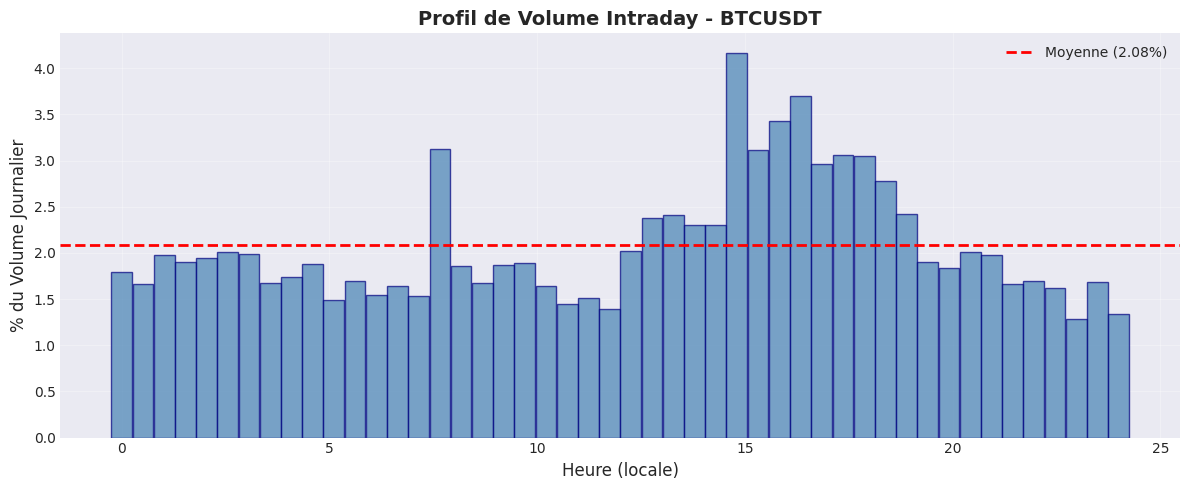

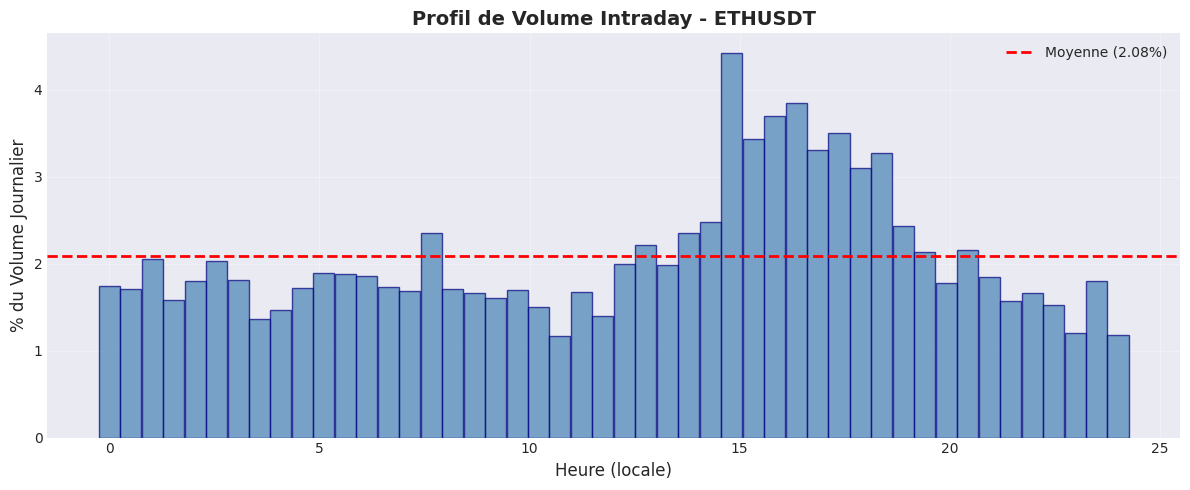

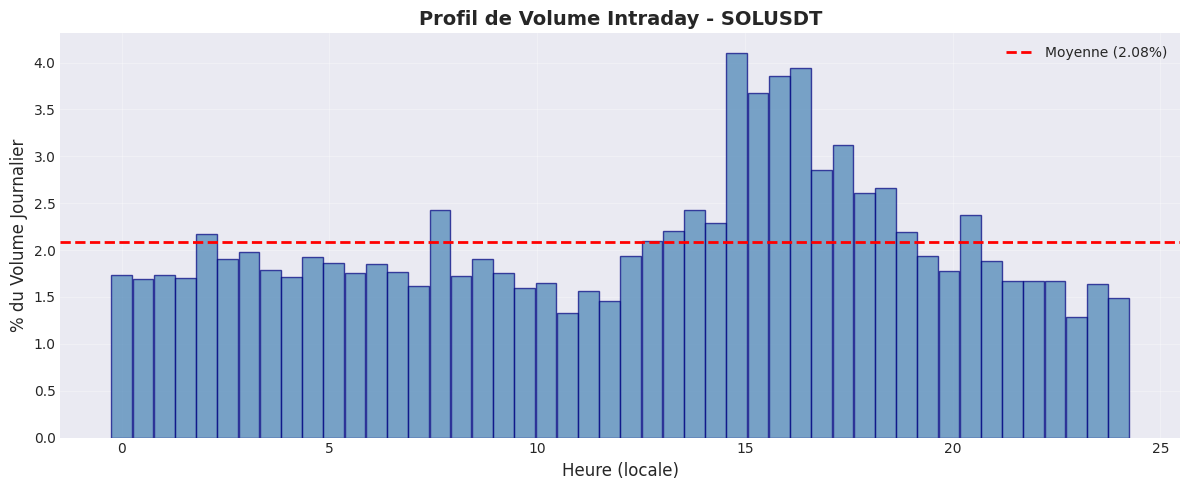

In [16]:
# Plot individual volume profiles for each cryptocurrency
for symbol, profile in crypto_profiles.items():
    plot_volume_profile(
        profile,
        title=f'Profil de Volume Intraday - {symbol}',
        trading_hours=(0, 24),
        figsize=(12, 5)
    )

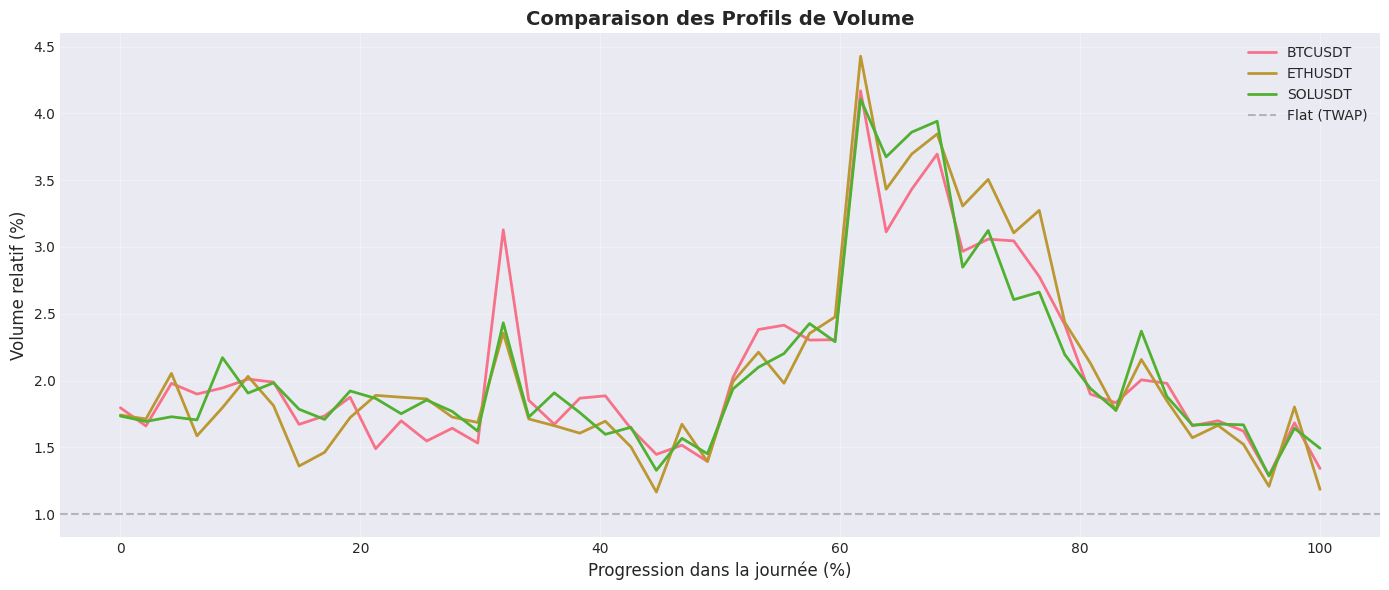

In [17]:
# Compare all crypto profiles on the same plot
compare_profiles(crypto_profiles, n_slices=N_SLICES_CRYPTO)

In [18]:
# Compute empirical intraday volume profiles for stocks (6.5h trading: 9:30-16:00)
N_SLICES_STOCK = 78  # 5-minute bins for 6.5h trading day

stock_profiles = {}
if len(processed_stock_data) > 0:
    for ticker, df in processed_stock_data.items():
        print(f'\nComputing volume profile for {ticker}...')
        # Reset index to have datetime as column
        df_reset = df.reset_index()
        profile = compute_volume_profile_from_data(
            df=df_reset,
            time_col='datetime',
            volume_col='volume',
            n_slices=N_SLICES_STOCK,
            trading_hours=(9.5, 16),  # 9:30 AM - 4:00 PM ET
            timezone='US/Eastern'  # Convert UTC timestamps to Eastern Time
        )
        stock_profiles[ticker] = profile
        print(f'   Profile shape: {profile.shape}, sum: {profile.sum():.4f}')
    
    print(f'\nStock profiles computed: {list(stock_profiles.keys())}')
else:
    print('No stock data available for volume profile computation')


Computing volume profile for AAPL...
   Profile shape: (78,), sum: 1.0000

Computing volume profile for MSFT...
   Profile shape: (78,), sum: 1.0000

Computing volume profile for GOOG...
   Profile shape: (78,), sum: 1.0000

Stock profiles computed: ['AAPL', 'MSFT', 'GOOG']


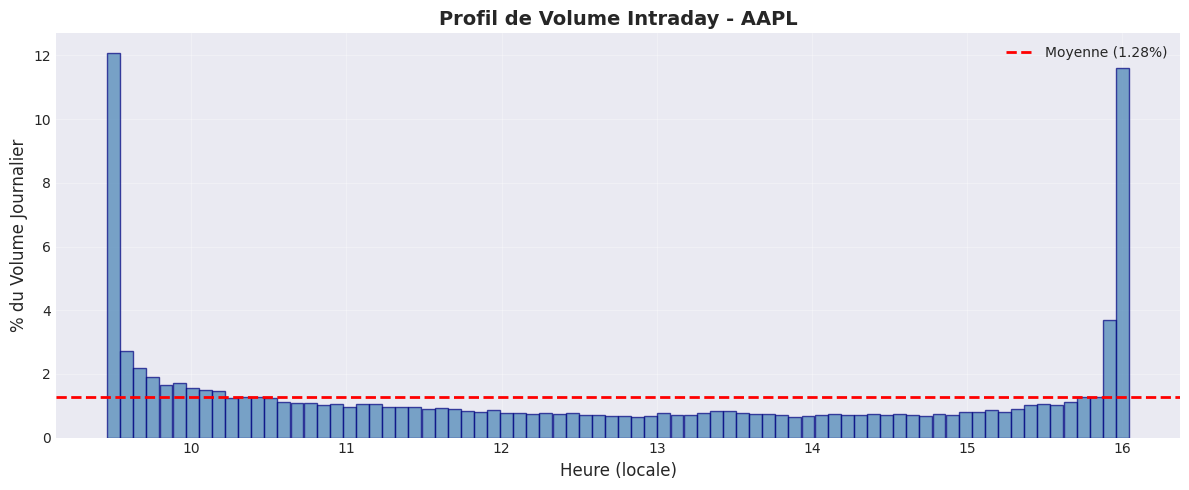

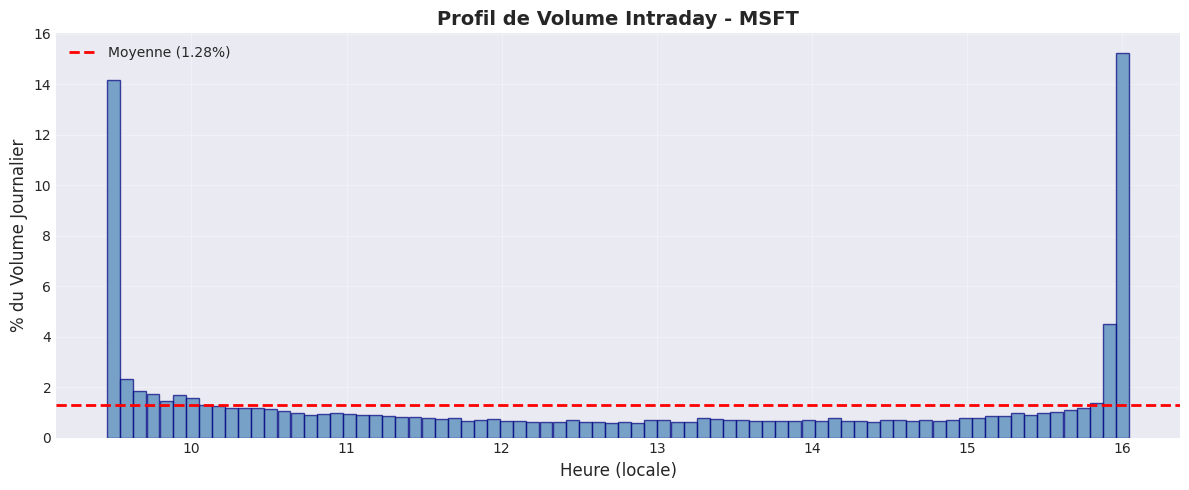

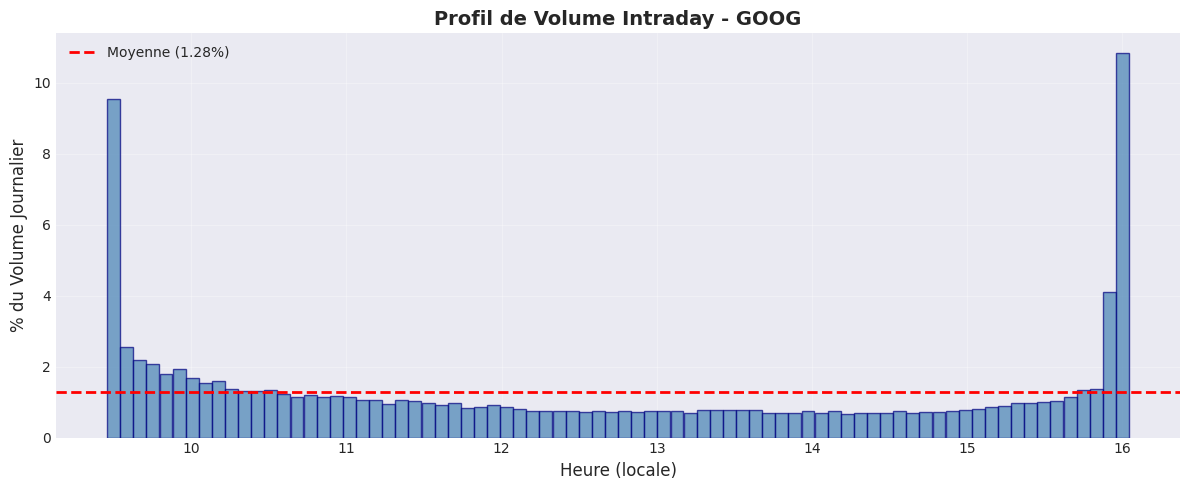

In [19]:
# Plot individual volume profiles for each stock
if len(stock_profiles) > 0:
    for ticker, profile in stock_profiles.items():
        plot_volume_profile(
            profile,
            title=f'Profil de Volume Intraday - {ticker}',
            trading_hours=(9.5, 16),
            figsize=(12, 5)
        )
else:
    print('No stock profiles to plot')

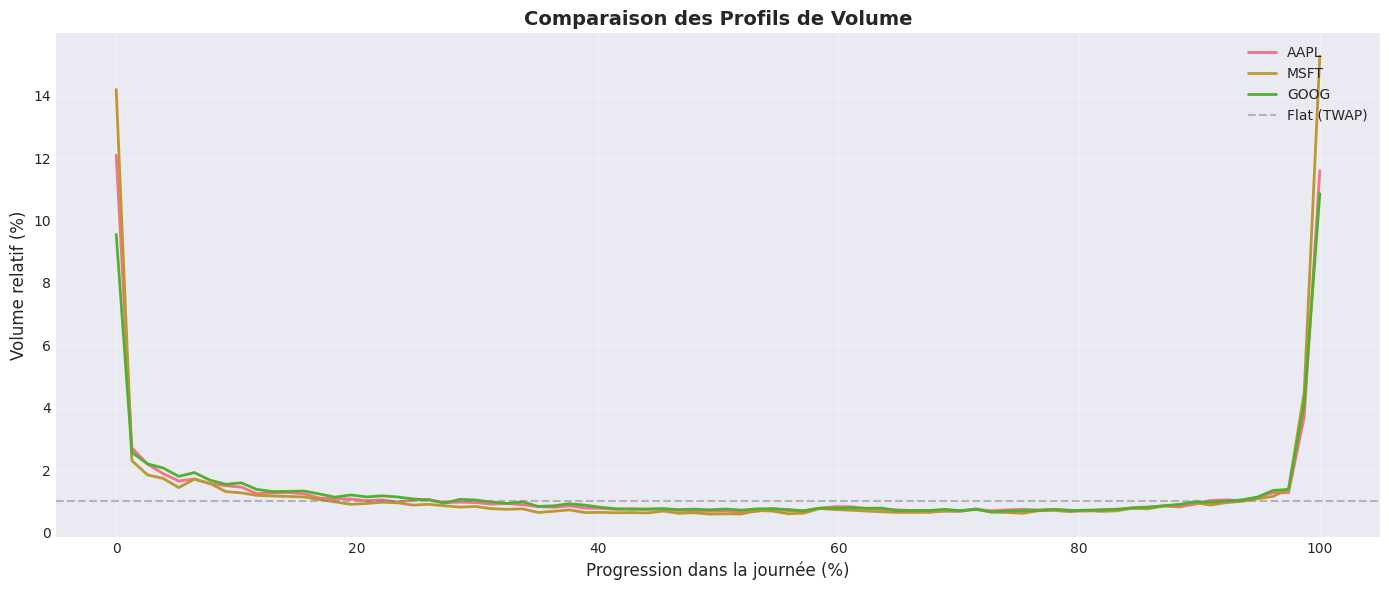

In [20]:
# Compare all stock profiles on the same plot
if len(stock_profiles) > 0:
    compare_profiles(stock_profiles, n_slices=N_SLICES_STOCK)
else:
    print('No stock profiles to compare')

## Summary

### Data collected:
- **Stocks**: AAPL, MSFT, GOOG (6 months, minute-level)
- **Cryptocurrencies**: BTCUSDT, ETHUSDT, SOLUSDT (1 month, minute-level)

### Files generated:
- `data/processed/stocks/`: Individual stock data files
- `data/processed/crypto/`: Individual crypto data files
- `data/processed/market_parameters.csv`: Market parameters (σ, V, S₀, spread)
- `data/processed/metadata.json`: Collection metadata

### Next steps:
Use these data files in the Almgren-Chriss model notebooks (02 and 03)